#### Download data from Kaggle

In [2]:
from kaggle_utils.src import KaggleDataApi

In [3]:
kda = KaggleDataApi(call_path = CURRENT_ROOT_DIR)
kda.download_kaggle_dataset(dataset_name="facial_keypoints_detection")

File downloaded and saved to:   c:\users\sankr\documents\projects\git_work\experiments\data\facial-keypoints-detection.zip


In [4]:
kda.unzip_and_return_folder_details()

('c:\\users\\sankr\\documents\\projects\\git_work\\experiments\\data\\facial-keypoints-detection',
 ['IdLookupTable.csv', 'SampleSubmission.csv', 'test.zip', 'training.zip'])

In [7]:
for file_name in ["test.zip", "training.zip"]:
    complete_path = os.path.join(root_folder, file_name)
    with zipfile.ZipFile(complete_path, 'r') as zip_ref:
        zip_ref.extractall(root_folder)

#### Pre-process test and train images to store as images and annotation

In [1]:
root_folder = "c:\\users\\sankr\\documents\\projects\\git_work\\experiments_cv_nlp\\data\\facial-keypoints-detection"
import os
import zipfile
import pandas as pd
import numpy as np

In [2]:
os.listdir(root_folder)

['IdLookupTable.csv',
 'SampleSubmission.csv',
 'test',
 'test.csv',
 'test.zip',
 'training',
 'training.csv',
 'training.zip']

In [3]:
annotation_file = os.path.join(root_folder, "IdLookupTable.csv")
submission_file = os.path.join(root_folder, "SampleSubmission.csv")
test_data = os.path.join(root_folder, "test.csv")
train_data = os.path.join(root_folder, "training.csv")

In [4]:
os.makedirs(os.path.join(root_folder, train_data.replace("csv", "")), exist_ok =True)
os.makedirs(os.path.join(root_folder, test_data.replace("csv", "")), exist_ok = True)

In [5]:
from PIL import Image

In [6]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv(train_data)

In [8]:
df["Image"] = df.Image.apply(lambda x: np.array(x.split(" "), dtype="float"))


In [9]:
df.Image[0].shape

(9216,)

In [10]:
df["Image"] = df.Image.apply(lambda pixel: pixel.reshape(96, 96, 1))
df["Image"] = df.Image.apply(lambda pixel: pixel/255)
images = df.pop("Image")

In [11]:
df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [12]:
images[0]

array([[[0.93333333],
        [0.9254902 ],
        [0.92941176],
        ...,
        [0.98039216],
        [0.98039216],
        [0.98039216]],

       [[0.92156863],
        [0.93333333],
        [0.9254902 ],
        ...,
        [0.97647059],
        [0.98039216],
        [0.98431373]],

       [[0.92941176],
        [0.9254902 ],
        [0.92941176],
        ...,
        [0.98431373],
        [0.98431373],
        [0.98039216]],

       ...,

       [[0.72941176],
        [0.71764706],
        [0.70980392],
        ...,
        [0.20392157],
        [0.22352941],
        [0.23529412]],

       [[0.74117647],
        [0.7372549 ],
        [0.81176471],
        ...,
        [0.23921569],
        [0.27058824],
        [0.30588235]],

       [[0.74901961],
        [0.72156863],
        [0.72156863],
        ...,
        [0.2745098 ],
        [0.29411765],
        [0.35294118]]])

In [13]:
isinstance(images[0], np.ndarray)

True

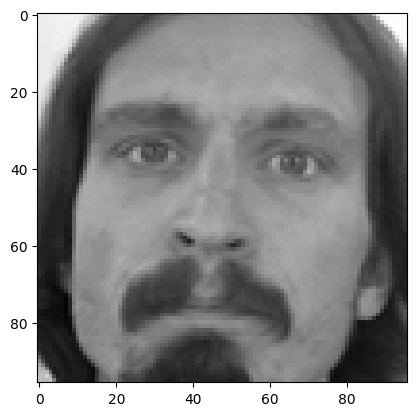

In [14]:
from matplotlib import pyplot as plt

plt.imshow(images[0], cmap="gray")

In [15]:
images[0].shape

(96, 96, 1)

#### Modelling

In [1]:
from src.cv.pytorch.datasets.facial_keypoint_detection.dataset import FacialKeypointDataset
from src.cv.model_pipelines.facial_keypoint_cnn_pipeline import FacialCNNTrainingPipeline

In [2]:
fkd = FacialKeypointDataset(
    dataset_name="faces", 
    data_type = "csv",
    data_file=r"data/facial-keypoints-detection/training.csv",
    resize_size=96,
    is_test=False
)


In [3]:
len(fkd)

7049

In [4]:
from src.cv.pytorch.models.use_cases.facial_keypoint_detection.utils import multi_view_image_keypoints, show_key_points_on_images

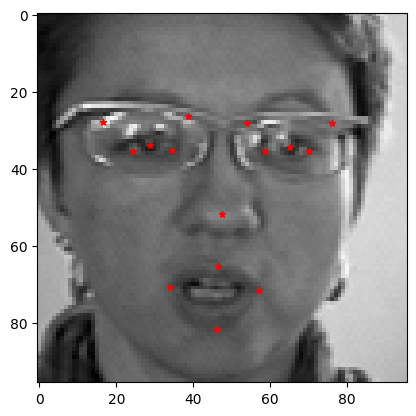

In [5]:
show_key_points_on_images(dataset=fkd, idx=10)

In [6]:
data = [fkd[i] for i in range(9)]

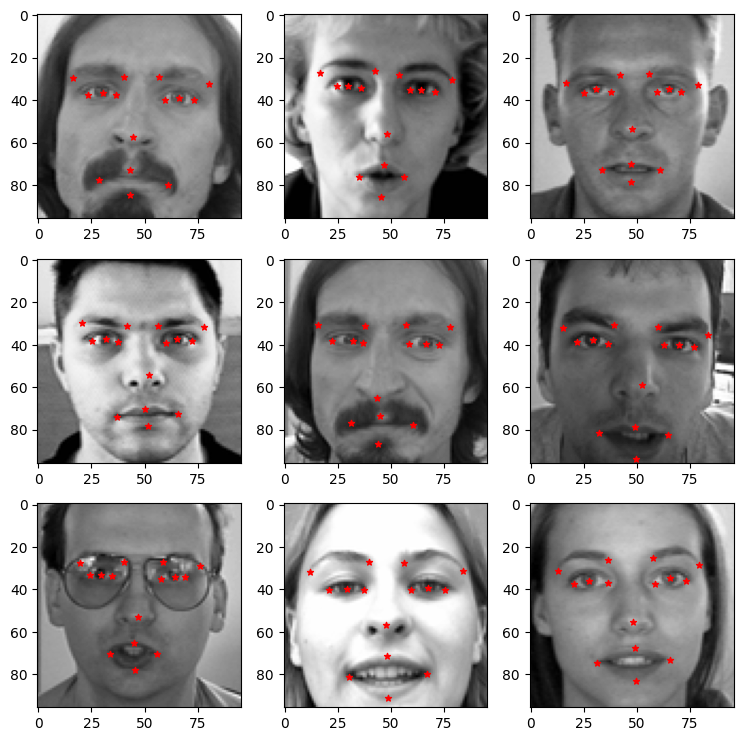

In [7]:
multi_view_image_keypoints(data=data)

#### V1 - Basecase

In [3]:
# Initial config for training
model_training_config = dict(
    learning_rate=0.05,
    batch_size=250,
    epochs=50,
    batch_norm_momentum=0.5
)
model_data_config = dict(
     dataset_size=len(fkd), train_data_pct=0.8, model_save_path="C:\\Users\\sankr\\Documents\\projects\\git_work\\experiments_cv_nlp\\data\\facial-keypoint-detection"
)

In [4]:
model_initialization_params=dict(
    cnn_layers = 3,
    input_channel = 1,
    output_channels = [32, 64, 96, 128, 30],
    kernel_sizes = [(5,5), (3,3), (3,3)],
    linear_layers = 2,
    dropout_addition_options=5, 
    dropout_threshold=0.2,
    cnn_batch_norm_flag = True
)

In [5]:
pwd

'C:\\Users\\sankr\\Documents\\projects\\git_work\\experiments_cv_nlp\\src\\cv\\model_pipelines\\notebooks'

In [6]:
facial_keypoint_pipeline = FacialCNNTrainingPipeline(
    dataset=fkd,
    model_data_config=model_data_config,
    model_initialization_params=model_initialization_params,
    model_training_config = model_training_config,
)

In [7]:
print(facial_keypoint_pipeline.model)

FacialKeypointVCNN(
  (conv2d1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2d1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch_norm2d1): BatchNorm2d(32, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (conv2d2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2d2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch_norm2d2): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (conv2d3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2d3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch_norm2d3): BatchNorm2d(96, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear1): LazyLinear(in_features=0, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=30, bias=True)
)


In [ ]:
facial_keypoint_pipeline.train()

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

root - INFO - Train Loss for epoch 0: 4333.2072 - 24-Jan-23 23:15:35
root - INFO - Validation Loss for epoch 0: 986.6223 - 24-Jan-23 23:16:20


  2%|█▌                                                                              | 1/50 [01:42<1:23:59, 102.85s/it]

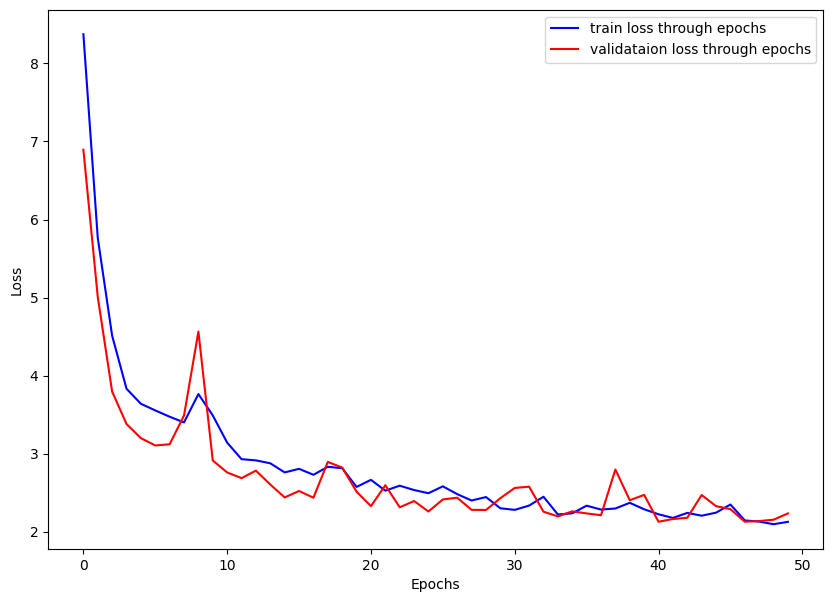

In [13]:
original_train_loss = facial_keypoint_pipeline.train_loss
original_validation_loss = facial_keypoint_pipeline.validation_loss

from matplotlib import pyplot as plt
import numpy as np

log_train_loss = [np.log(loss) for loss in original_train_loss]
log_validation_loss = [np.log(loss) for loss in original_validation_loss]
plt.figure(figsize=(10, 7))
plt.plot(log_train_loss, color='blue', label='train loss through epochs')
plt.plot(log_validation_loss, color='red', label='validataion loss through epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
        

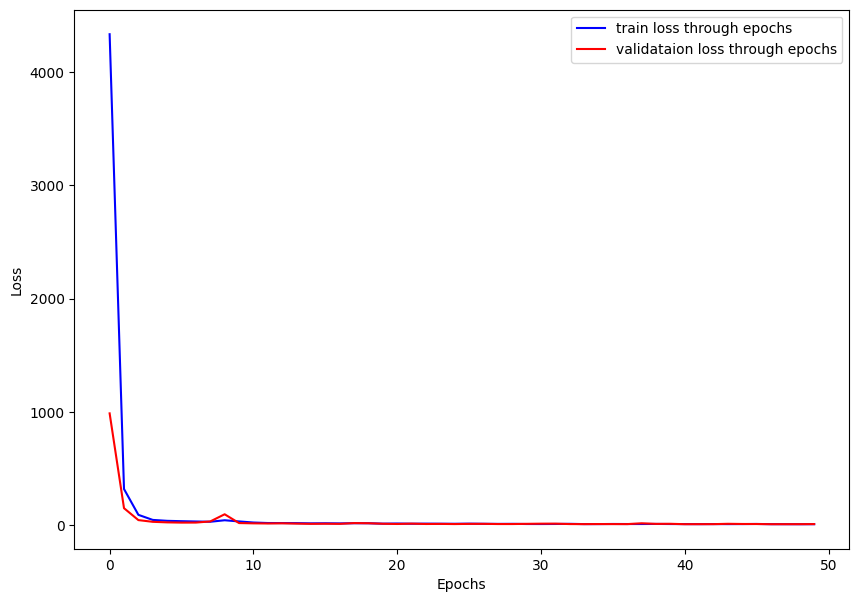

In [14]:
facial_keypoint_pipeline.generate_train_validation_loss_curves()

- Addition of batch_normalization is very helpful in improving performance, and before this -> the network had high values for both train and validation loss.
Initial high values of loss are from random initialization of weights and can be ignores. the above model cannot handle missing values. We are currently doing a ffil on these values.

- The next step would be to compare the above with a ResNet because of its ability to handle missing values in target keypoints.

- We also compare the above with OpenCV based cascade classifiers and feature engineering

In [2]:
fkd_test = FacialKeypointDataset(
    dataset_name="faces", 
    data_type = "csv",
    data_file=r"data/facial-keypoints-detection/test.csv",
    resize_size=96,
    is_test=True
)

> c:\users\sankr\documents\projects\git_work\experiments_cv_nlp\src\cv\pytorch\datasets\facial_keypoint_detection\dataset.py(86)_load_custom_image_data()
     84         import pdb
     85         pdb.set_trace()
---> 86         data.fillna(method = 'ffill',inplace = True)
     87         image_data = data.pop(self.__image_column)
     88         self._image_labels = data

ipdb> c


In [4]:
from torch.utils.data import DataLoader
import multiprocessing as mp

test_dataloader = DataLoader(
        fkd_test, 
        num_workers=mp.cpu_count() - 2, 
    )

In [34]:
preds = facial_keypoint_pipeline.get_predictions(
    test_dataloader=test_dataloader, device=facial_keypoint_pipeline.model_training_config.device
)

In [27]:
model = facial_keypoint_pipeline.best_model